In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

#data: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_path = "/content/drive/MyDrive/amazon-sentiment/train.ft.txt"
test_path = "/content/drive/MyDrive/amazon-sentiment/test.ft.txt"

In [4]:
with open (train_path, "r", encoding='utf8') as f:
    lines = f.readlines()

In [5]:
for i in range (0, 5):
    print(lines[i])

__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^

__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.

__label__2 Amazing!: This soundtrack is

In [6]:
len(lines)

3600000

In [7]:
lines[1][9:10]

'2'

In [8]:
lines[2][11:-2]

'Amazing!: This soundtrack is my favorite music of all time, hands down. The intense sadness of "Prisoners of Fate" (which means all the more if you\'ve played the game) and the hope in "A Distant Promise" and "Girl who Stole the Star" have been an important inspiration to me personally throughout my teen years. The higher energy tracks like "Chrono Cross ~ Time\'s Scar~", "Time of the Dreamwatch", and "Chronomantique" (indefinably remeniscent of Chrono Trigger) are all absolutely superb as well.This soundtrack is amazing music, probably the best of this composer\'s work (I haven\'t heard the Xenogears soundtrack, so I can\'t say for sure), and even if you\'ve never played the game, it would be worth twice the price to buy it.I wish I could give it 6 stars'

In [9]:
reviews = []     #A list to store reviews
ratings = []     #A list to store ratings

random.Random(1704).shuffle(lines)

In [10]:
for i in range(int(0.1*len(lines))):
    ratings.append(lines[i][9:10])
    reviews.append(lines[i][11:-2])

In [11]:
type(reviews)
length=[]
for i in reviews:
    length.append(len(i))
print("Mean Length of review", sum(length)/len(length))
print("Longest review: ", max(length), "\nShortest Review", min(length))

Mean Length of review 430.3313972222222
Longest review:  1014 
Shortest Review 71


In [12]:
type(reviews[1])

str

In [13]:
type(ratings[1])

str

In [14]:
for i in range(len(ratings)):
    ratings[i] = int(ratings[i]) #Converting datatype of ratings from str to int
    ratings[i] = ratings[i] - 1  #Converting 1,2 for negative and positive to 0,1 for negative and positive

In [15]:
type(ratings[1])

int

In [16]:
ratings[1:10]

[1, 0, 0, 1, 1, 0, 1, 1, 0]

In [17]:
dataset = {'reviews': reviews, 'ratings': ratings}
dataset = pd.DataFrame(dataset)

In [18]:
dataset

,reviews,ratings
0,easily the best book about Citizen Kane!: Carr...,1
1,The best Modern Greek dictionary around: i thi...,1
2,"The Mermaid Chair- Not all that great: Okay, I...",0
3,My head still hurts.: I particularly loved the...,0
4,Twinings pulled off a miracle!: I'm a devout n...,1
...,...,...
359995,Action packed!!!: Iron Man (Single-Disc Editio...,1
359996,"""Wonderful"": ""OMG"", This is by far the best pr...",1
359997,Mankind versus me...: This is the best ska roc...,1
359998,"Masterpiece or Mess?: When I saw ""AI"" in the m...",0


In [19]:
dataset.groupby(['ratings']).count()

,reviews
ratings,
0,179787
1,180213


In [20]:
dataset.dtypes

reviews    object
ratings     int64
dtype: object

In [21]:
#Following code can be run, and the summarized list can replace the reviews list 
#for the rest of the notebook, but it takes too long to execute

'''summarized = []

for i in range(len(reviews)):
    body = reviews[i]
    bert_model = Summarizer()
    bert_summary = ''.join(bert_model(body, min_length=60))
    summarized.append(bert_summary)
    
'''

"summarized = []\n\nfor i in range(len(reviews)):\n    body = reviews[i]\n    bert_model = Summarizer()\n    bert_summary = ''.join(bert_model(body, min_length=60))\n    summarized.append(bert_summary)\n    \n"

In [22]:
features, targets = dataset['reviews'], dataset['ratings']

train_features, test_features, train_targets, test_targets = train_test_split(
        features, targets,
        train_size=0.9,
        test_size=0.1,
        random_state=42,
        shuffle = True,
        stratify=targets
    )

In [23]:
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
    tf.cast(train_features.values, tf.string)
) 

train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(train_targets.values, tf.int64),

) 

test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(test_features.values, tf.string)
) 

test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(test_targets.values, tf.int64),

)

In [24]:
MAX_LENGTH=300
VOCAB_SIZE = 30000

vectorizer = tf.keras.layers.TextVectorization(
                max_tokens=VOCAB_SIZE,
                output_mode="int",
                output_sequence_length=MAX_LENGTH,
            )

In [25]:
vectorizer.adapt(train_features)
vocab = vectorizer.get_vocabulary()
len(vocab)

30000

In [26]:
train_text_ds_raw.element_spec

TensorSpec(shape=(), dtype=tf.string, name=None)

In [27]:
def convert_text_input(sample):
    text = sample
    text = tf.expand_dims(text, -1) 
    return tf.squeeze(vectorizer(text))

In [28]:
train_text_ds = train_text_ds_raw.map(convert_text_input, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_text_ds = test_text_ds_raw.map(convert_text_input, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [29]:
train_text_ds.element_spec

TensorSpec(shape=<unknown>, dtype=tf.int64, name=None)

In [30]:
for each in train_text_ds.take(1):
    print(each)

tf.Tensor(
[  182  1015   359 23191   182     1  1015    32   556     8    10  1144
     1    90    10    27   182    82     4    60    21     6  1485     6
    51    22 23191    11     8    44    42   666  1596   603    90    10
   182     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

In [31]:
train_ds = tf.data.Dataset.zip((train_text_ds, train_cat_ds_raw))

In [32]:
test_ds = tf.data.Dataset.zip((test_text_ds, test_cat_ds_raw))

In [33]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE
BUFFER_SIZE = train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=BUFFER_SIZE)\
                   .batch(batch_size=BATCH_SIZE,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=BUFFER_SIZE)\
                   .batch(batch_size=BATCH_SIZE,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

In [34]:
def create_model():
    inputs = layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32)
    embedding_layer = layers.Embedding(VOCAB_SIZE, 256)
    x = embedding_layer(inputs)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(2, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['Accuracy'])  
    return model


my_model=create_model()
my_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 256)          7680000   
                                                                 
 flatten (Flatten)           (None, 76800)             0         
                                                                 
 dense (Dense)               (None, 64)                4915264   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 12,595,394
Trainable params: 12,595,394
Non-tra

In [35]:
callbacks = [keras.callbacks.ModelCheckpoint('amazon1.keras', save_best_only=True),
             keras.callbacks.EarlyStopping(patience=5)]

In [36]:
history = my_model.fit(train_ds, epochs=25, callbacks=callbacks, validation_data=test_ds)

Epoch 1/25
5062/5062 [==============================] - 78s 10ms/step - loss: 0.2657 - Accuracy: 0.8885 - val_loss: 0.2179 - val_Accuracy: 0.9138
Epoch 2/25
5062/5062 [==============================] - 44s 9ms/step - loss: 0.1548 - Accuracy: 0.9399 - val_loss: 0.2601 - val_Accuracy: 0.9079
Epoch 3/25
5062/5062 [==============================] - 44s 9ms/step - loss: 0.0645 - Accuracy: 0.9762 - val_loss: 0.4095 - val_Accuracy: 0.8996
Epoch 4/25
5062/5062 [==============================] - 52s 10ms/step - loss: 0.0315 - Accuracy: 0.9888 - val_loss: 0.5901 - val_Accuracy: 0.8949
Epoch 5/25
5062/5062 [==============================] - 45s 9ms/step - loss: 0.0219 - Accuracy: 0.9925 - val_loss: 0.7207 - val_Accuracy: 0.8959
Epoch 6/25
5062/5062 [==============================] - 45s 9ms/step - loss: 0.0160 - Accuracy: 0.9945 - val_loss: 0.8302 - val_Accuracy: 0.8932


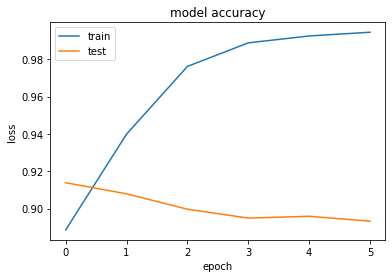

In [37]:
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.show()

In [38]:
loss, accuracy = my_model.evaluate(test_ds)
print("Train accuracy: ", accuracy)

562/562 [==============================] - 1s 2ms/step - loss: 0.8302 - Accuracy: 0.8932
Train accuracy:  0.8932106494903564


In [39]:
my_model = keras.models.load_model('amazon1.keras')

In [40]:
inputs = keras.Input(shape=(1,), dtype='string')
x = vectorizer(inputs)
outputs = my_model(x)
end_to_end_model = keras.Model(inputs, outputs)
end_to_end_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
end_to_end_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 model (Functional)          (None, 2)                 12595394  
                                                                 
Total params: 12,595,394
Trainable params: 12,595,394
Non-trainable params: 0
_________________________________________________________________


In [41]:
test_review = "this is incredible awesome loved it"
type(test_review)

str

In [44]:
pred = end_to_end_model.predict([test_review])
print(np.argmax(pred[0]))

1


In [46]:
pred

array([[0.00143103, 0.9985689 ]], dtype=float32)

In [45]:
loss, accuracy = end_to_end_model.evaluate(test_features,test_targets)
print("end_to_end_model accuracy: ", accuracy)

1125/1125 [==============================] - 4s 4ms/step - loss: 0.2179 - accuracy: 0.9139
end_to_end_model accuracy:  0.913861095905304
